# Modélisation Prophet (baseline + regressors)

**Objectif :** entraîner un modèle de prévision des admissions (`y`) à partir de la série temporelle (`ds`) pour un service (ex: Urgences).

Plan :
1) Baseline Prophet : uniquement `ds` et `y`
2) Modèle enrichi : ajout de variables exogènes (`is_winter`, événements) pour améliorer l’interprétation et simuler des scénarios
3) Évaluation simple sur une période de test (MAE / RMSE / MAPE)


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet

In [14]:
DATA_PATH = "../data/synthetic/hospital_daily_activity.csv"
SERVICE = "Urgences"

df = pd.read_csv(DATA_PATH)
df["ds"] = pd.to_datetime(df["ds"])

df_s = df[df["service"] == SERVICE].sort_values("ds").copy()
df_s.head()

,ds,y,service,beds_occupied,staff_on_duty,is_winter,event
0,2018-01-01,462,Urgences,200,122,1,flu
3,2018-01-02,466,Urgences,200,113,1,flu
6,2018-01-03,439,Urgences,200,116,1,flu
9,2018-01-04,433,Urgences,200,112,1,flu
12,2018-01-05,467,Urgences,200,120,1,flu


## 1) Train/Test split

On garde les dernières semaines/mois comme période de test pour évaluer la capacité de prédiction.
Exemple : les 90 derniers jours en test.


In [15]:
HORIZON_DAYS = 90

cutoff = df_s["ds"].max() - pd.Timedelta(days=HORIZON_DAYS)
train = df_s[df_s["ds"] <= cutoff].copy()
test  = df_s[df_s["ds"] >  cutoff].copy()

print("Train:", train.shape, "Test:", test.shape)
print("Cutoff:", cutoff.date())


Train: (2832, 7) Test: (90, 7)
Cutoff: 2025-10-02


## 2) Baseline Prophet (ds, y)

On entraîne Prophet avec la saisonnalité hebdomadaire et annuelle (par défaut),
ce qui est adapté à une activité hospitalière.

In [16]:
train_base = train[["ds", "y"]].copy()

m_base = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

m_base.fit(train_base)

future = m_base.make_future_dataframe(periods=HORIZON_DAYS, freq="D")
forecast_base = m_base.predict(future)

forecast_base[["ds","yhat","yhat_lower","yhat_upper"]].tail()


10:22:50 - cmdstanpy - INFO - Chain [1] start processing
10:22:51 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
2917,2025-12-27,351.985491,310.914910,391.947525
2918,2025-12-28,353.564977,315.775731,390.046582
2919,2025-12-29,354.266348,315.262515,392.764962
2920,2025-12-30,356.742483,317.902281,396.894230
2921,2025-12-31,359.442832,320.822376,399.353539


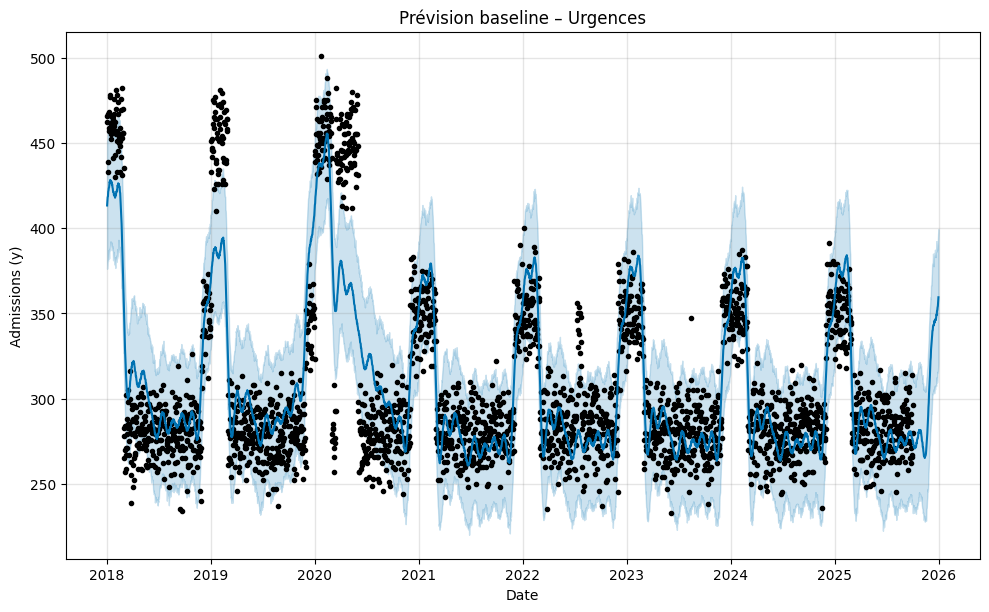

In [17]:
fig = m_base.plot(forecast_base)
plt.title(f"Prévision baseline – {SERVICE}")
plt.xlabel("Date")
plt.ylabel("Admissions (y)")
plt.show()

In [18]:
pred_base = forecast_base[["ds", "yhat"]].merge(test[["ds", "y"]], on="ds", how="inner")

pred_base.head(), pred_base.shape

(          ds        yhat    y
 0 2025-10-03  274.854077  262
 1 2025-10-04  273.312208  315
 2 2025-10-05  272.776080  302
 3 2025-10-06  271.318270  283
 4 2025-10-07  271.629245  271,
 (90, 3))

## 3) Évaluation (MAE / RMSE / MAPE)

Ces métriques quantifient l’erreur moyenne sur la période de test.


In [19]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100

y_true = pred_base["y"].values
y_pred = pred_base["yhat"].values

print("MAE :", round(mae(y_true, y_pred), 2))
print("RMSE:", round(rmse(y_true, y_pred), 2))
print("MAPE:", round(mape(y_true, y_pred), 2), "%")


MAE : 15.14
RMSE: 18.62
MAPE: 4.9 %


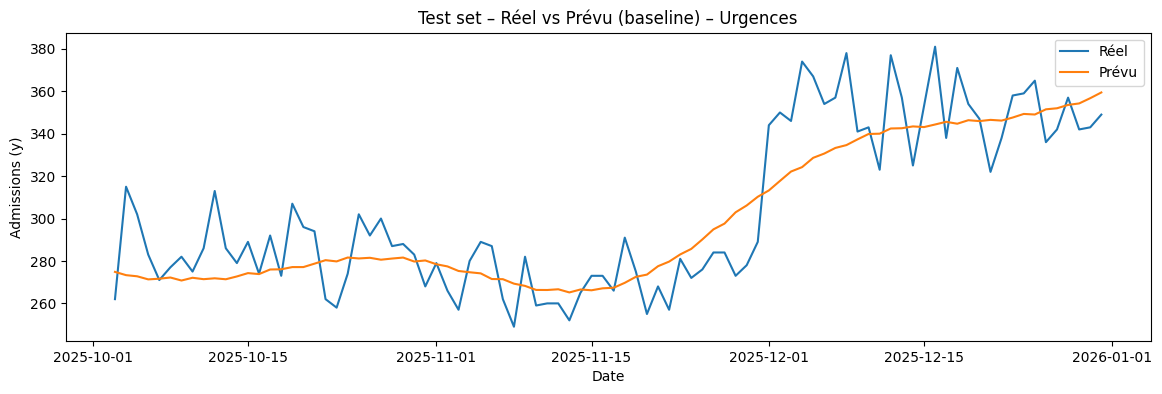

In [20]:
plt.figure(figsize=(14,4))
plt.plot(pred_base["ds"], pred_base["y"], label="Réel")
plt.plot(pred_base["ds"], pred_base["yhat"], label="Prévu")
plt.title(f"Test set – Réel vs Prévu (baseline) – {SERVICE}")
plt.xlabel("Date")
plt.ylabel("Admissions (y)")
plt.legend()
plt.show()


## 4) Prophet + variables exogènes (regressors)

On ajoute des variables contextuelles pour :
- mieux expliquer les pics (hiver, événements)
- améliorer l’interprétation des prévisions
- permettre des scénarios (ex: activation d’un événement)

Ici : `is_winter` (0/1) et `event` (one-hot encoding).


In [ ]:
df_reg = df_s[["ds", "y", "is_winter", "event"]].copy()

df_reg = pd.get_dummies(df_reg, columns=["event"], drop_first=False)

event_cols_all = [c for c in df_reg.columns if c.startswith("event_")]
df_reg[event_cols_all] = df_reg[event_cols_all].astype(int)
df_reg["is_winter"] = df_reg["is_winter"].astype(int)

df_reg.head()


,ds,y,is_winter,event_covid,event_flu,event_heatwave,event_none
0,2018-01-01,462,1,0,1,0,0
3,2018-01-02,466,1,0,1,0,0
6,2018-01-03,439,1,0,1,0,0
9,2018-01-04,433,1,0,1,0,0
12,2018-01-05,467,1,0,1,0,0


In [ ]:
# Split train/test
train_reg = df_reg[df_reg["ds"] <= cutoff].copy()
test_reg  = df_reg[df_reg["ds"] >  cutoff].copy()

print("Train_reg:", train_reg.shape, "Test_reg:", test_reg.shape)
train_reg.head()


Train_reg: (2832, 7) Test_reg: (90, 7)


,ds,y,is_winter,event_covid,event_flu,event_heatwave,event_none
0,2018-01-01,462,1,0,1,0,0
3,2018-01-02,466,1,0,1,0,0
6,2018-01-03,439,1,0,1,0,0
9,2018-01-04,433,1,0,1,0,0
12,2018-01-05,467,1,0,1,0,0


In [30]:
event_cols = [c for c in train_reg.columns if c.startswith("event_") and c != "event_none"]
event_cols


['event_covid', 'event_flu', 'event_heatwave']

In [31]:
m_reg = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

m_reg.add_regressor("is_winter")

for c in event_cols:
    m_reg.add_regressor(c)

cols_fit = ["ds", "y", "is_winter"] + event_cols
m_reg.fit(train_reg[cols_fit])


12:07:24 - cmdstanpy - INFO - Chain [1] start processing
12:07:24 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
future_reg = m_reg.make_future_dataframe(periods=HORIZON_DAYS, freq="D")

future_reg["is_winter"] = future_reg["ds"].dt.month.isin([12, 1, 2]).astype(int)

for c in event_cols:
    future_reg[c] = 0

forecast_future_reg = m_reg.predict(future_reg)
forecast_future_reg[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()


,ds,yhat,yhat_lower,yhat_upper
2917,2025-12-27,352.129842,332.791227,371.170345
2918,2025-12-28,351.573417,332.858839,370.821450
2919,2025-12-29,350.915817,331.524975,369.602953
2920,2025-12-30,351.282602,332.829669,369.846572
2921,2025-12-31,351.629236,332.965720,371.068857


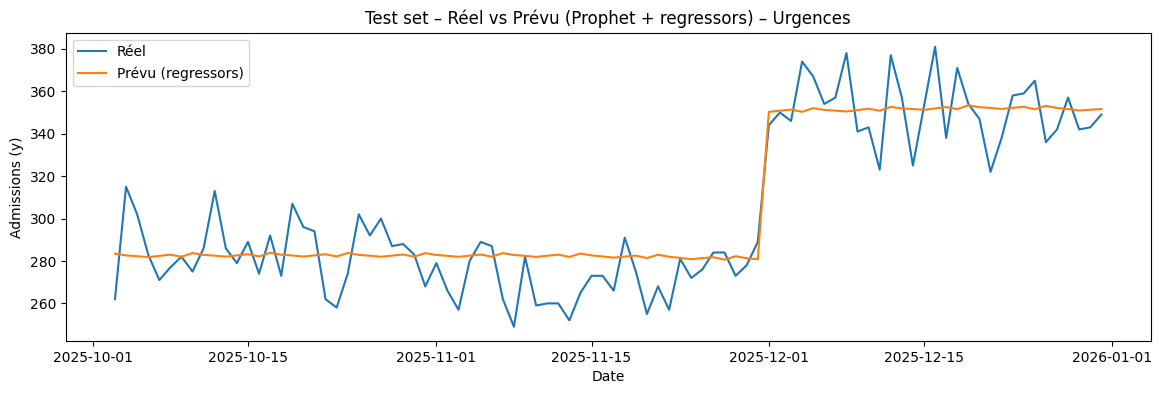

In [34]:
plt.figure(figsize=(14,4))
plt.plot(pred_reg["ds"], pred_reg["y"], label="Réel")
plt.plot(pred_reg["ds"], pred_reg["yhat"], label="Prévu (regressors)")
plt.title(f"Test set – Réel vs Prévu (Prophet + regressors) – {SERVICE}")
plt.xlabel("Date")
plt.ylabel("Admissions (y)")
plt.legend()
plt.show()


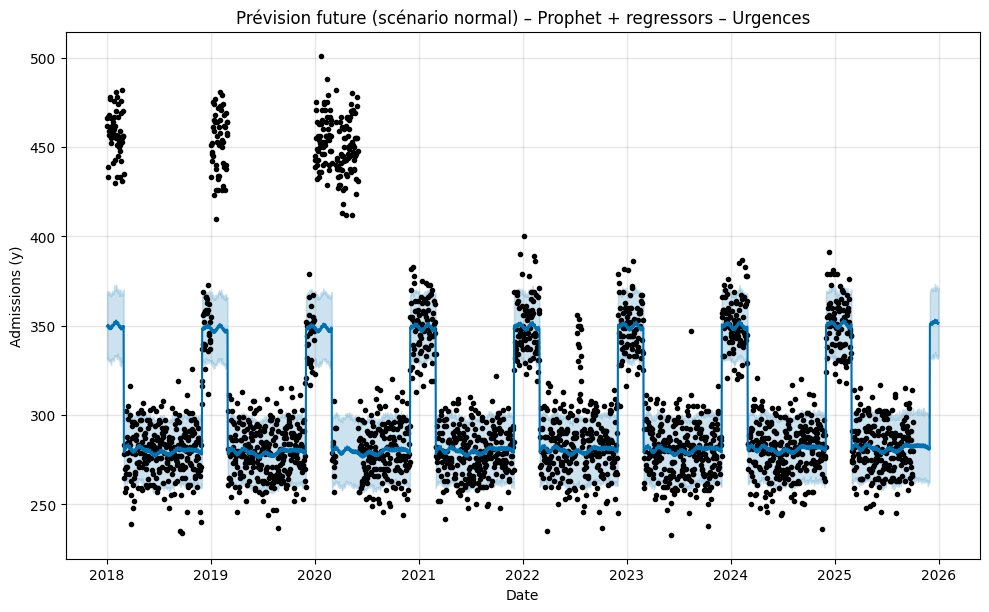

In [33]:
X_all = df_reg[["ds", "is_winter"] + event_cols].copy()
forecast_reg_all = m_reg.predict(X_all)

pred_reg = forecast_reg_all[["ds", "yhat"]].merge(test_reg[["ds", "y"]], on="ds", how="inner")

y_true2 = pred_reg["y"].values
y_pred2 = pred_reg["yhat"].values

print("MAE :", round(mae(y_true2, y_pred2), 2))
print("RMSE:", round(rmse(y_true2, y_pred2), 2))
print("MAPE:", round(mape(y_true2, y_pred2), 2), "%")

pred_reg.head()



MAE : 12.49
RMSE: 15.49
MAPE: 4.22 %


,ds,yhat,y
0,2025-10-03,283.448203,262
1,2025-10-04,282.608638,315
2,2025-10-05,282.244474,302
3,2025-10-06,281.801308,283
4,2025-10-07,282.400201,271


## 5) Comparaison baseline vs regressors

On compare les métriques pour vérifier l’intérêt des variables contextuelles.


In [26]:
baseline_metrics = {
    "MAE": mae(y_true, y_pred),
    "RMSE": rmse(y_true, y_pred),
    "MAPE": mape(y_true, y_pred),
}

reg_metrics = {
    "MAE": mae(y_true2, y_pred2),
    "RMSE": rmse(y_true2, y_pred2),
    "MAPE": mape(y_true2, y_pred2),
}

pd.DataFrame([baseline_metrics, reg_metrics], index=["Baseline", "Regressors"])


,MAE,RMSE,MAPE
Baseline,15.143451,18.624911,4.902184
Regressors,104.492750,105.595010,35.279775


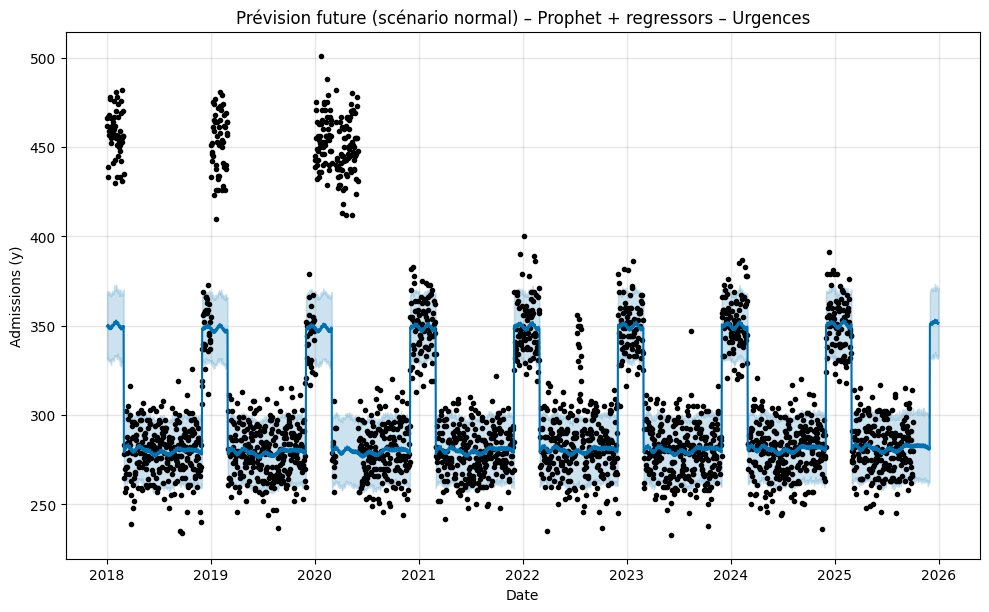

In [ ]:
#Scénario Normal : Prévision ( simulation) 
fig = m_reg.plot(forecast_future_reg)
plt.title(f"Prévision future (scénario normal) – Prophet + regressors – {SERVICE}")
plt.xlabel("Date")
plt.ylabel("Admissions (y)")
plt.show()
